In [27]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import re
import sys
import csv
import os
from progressbar import *

In [28]:
data1 = pd.read_csv('e:\wine_data\winemag-data_first150k.csv')
data2 = pd.read_csv('e:\wine_data\winemag-data-130k-v2.csv')
wine = pd.concat([data1, data2], ignore_index=True, sort=False)
wine=wine.drop(labels='Unnamed: 0', axis=1)
wine.info()
wine.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280901 entries, 0 to 280900
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                280833 non-null  object 
 1   description            280901 non-null  object 
 2   designation            197701 non-null  object 
 3   points                 280901 non-null  int64  
 4   price                  258210 non-null  float64
 5   province               280833 non-null  object 
 6   region_1               234594 non-null  object 
 7   region_2               111464 non-null  object 
 8   variety                280900 non-null  object 
 9   winery                 280901 non-null  object 
 10  taster_name            103727 non-null  object 
 11  taster_twitter_handle  98758 non-null   object 
 12  title                  129971 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 27.9+ MB


country                      68
description                   0
designation               83200
points                        0
price                     22691
province                     68
region_1                  46307
region_2                 169437
variety                       1
winery                        0
taster_name              177174
taster_twitter_handle    182143
title                    150930
dtype: int64

In [29]:
dataset = []

feature_names = ["country", "points", "price", 
                     "province", "region_1", "region_2", "variety","winery"]
wine1 = wine[feature_names]
wine1 = wine1.dropna(how = 'any')
wine1.dropna(axis=0,inplace=False)


#print(np.isnan(wine1).any())
rows = wine1.values.tolist()
print(rows[5])
for data_line in rows:
    data_set = []
    for i,value in enumerate(data_line):
        if not value:
            data_set.append((feature_names[i], 'NA'))
        else:           
            data_set.append((feature_names[i], value))             
    dataset.append(data_set)

['US', 95, 48.0, 'Oregon', 'Ribbon Ridge', 'Willamette Valley', 'Pinot Noir', 'Patricia Green Cellars']


In [30]:
def Create_C1(dataset):#频繁模式挖掘
    C1 = []
    progress = ProgressBar()
    for data in progress(dataset):
        for item in data:
            if [item] not in C1:
                C1.append([item])
    print("Created success")
    return [frozenset(item) for item in C1]

def scan_D(dataset, Ck):
    Ck_count = dict()
    for data in dataset:
        for cand in Ck:
            if cand.issubset(data):
                if cand not in Ck_count:
                    Ck_count[cand] = 1
                else:
                    Ck_count[cand] += 1

    num_items = float(len(dataset))
    return_list = []
    support_data = dict()
        # 过滤非频繁项集
    for key in Ck_count:
        support  = Ck_count[key] / num_items
        if support >= 0.1:
              return_list.insert(0, key)
        support_data[key] = support
    return return_list, support_data
def apriori_gen(Lk, k):
        return_list = []
        len_Lk = len(Lk)
        for i in range(len_Lk):
            for j in range(i+1, len_Lk):
                L1 = list(Lk[i])[:k-2]
                L2 = list(Lk[j])[:k-2]
                L1.sort()
                L2.sort()
                if L1 == L2:
                    return_list.append(Lk[i] | Lk[j])
        return return_list
def apriori(dataset):
    C1 = Create_C1(dataset)
    dataset = [set(data) for data in dataset]
    L1, support_data = scan_D(dataset, C1)
    L = [L1]
    k = 2
    while len(L[k-2]) > 0:
        Ck = apriori_gen(L[k-2], k)
        Lk, support_k = scan_D(dataset, Ck)
        support_data.update(support_k)
        L.append(Lk)
        k += 1
    return L, support_data

In [31]:
freq_set, sup_rata = apriori(dataset)
sup_rata_out = sorted(sup_rata.items(), key=lambda d: d[1], reverse=True)

100% |########################################################################|


Created success


In [32]:
freq_set_file = open(os.path.join('E:', 'fterms.json'), 'w')
for (key, value) in sup_rata_out:
            result_dict = {'set': None, 'sup': None}
            set_result = list(key)
            sup_result = value
            if sup_result < 0.1:
                continue
            result_dict['set'] = set_result
            result_dict['sup'] = sup_result
            json_str = json.dumps(result_dict, ensure_ascii=False)
            freq_set_file.write(json_str + '\n')
freq_set_file.close()

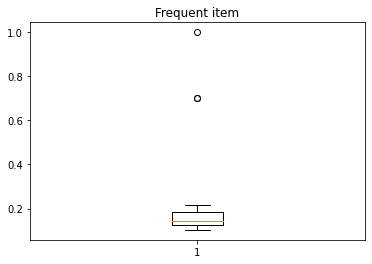

In [33]:
with open("E:/fterms.json") as f1:
  freq = [json.loads(each) for each in f1.readlines()]
  freq_sup = [each["sup"] for each in freq]
  plt.figure()
  plt.title("Frequent item")
  plt.boxplot(freq_sup)
  plt.show()

In [34]:
freq


[{'set': [['country', 'US']], 'sup': 1.0},
 {'set': [['province', 'California']], 'sup': 0.7036379689358175},
 {'set': [['country', 'US'], ['province', 'California']],
  'sup': 0.7036379689358175},
 {'set': [['region_2', 'Central Coast']], 'sup': 0.21588165339291507},
 {'set': [['region_2', 'Central Coast'], ['province', 'California']],
  'sup': 0.21588165339291507},
 {'set': [['country', 'US'], ['region_2', 'Central Coast']],
  'sup': 0.21588165339291507},
 {'set': [['country', 'US'],
   ['region_2', 'Central Coast'],
   ['province', 'California']],
  'sup': 0.21588165339291507},
 {'set': [['region_2', 'Sonoma']], 'sup': 0.18219575480197484},
 {'set': [['province', 'California'], ['region_2', 'Sonoma']],
  'sup': 0.18219575480197484},
 {'set': [['country', 'US'], ['region_2', 'Sonoma']],
  'sup': 0.18219575480197484},
 {'set': [['country', 'US'],
   ['province', 'California'],
   ['region_2', 'Sonoma']],
  'sup': 0.18219575480197484},
 {'set': [['variety', 'Pinot Noir']], 'sup': 0.172

In [35]:
def generate_rules(L, support_data):
        big_rules_list = []
        for i in range(1, len(L)):
            for freq_set in L[i]:
                H1 = [frozenset([item]) for item in freq_set]
                if i > 1:
                    rules_from_conseq(freq_set, H1, support_data, big_rules_list)
                else:
                    cal_conf(freq_set, H1, support_data, big_rules_list)
        return big_rules_list

def rules_from_conseq(freq_set, H, support_data, big_rules_list):
        m = len(H[0])
        if len(freq_set) > (m+1):
            Hmp1 = apriori_gen(H, m+1)
            Hmp1 = cal_conf(freq_set, Hmp1, support_data, big_rules_list)
            if len(Hmp1) > 1:
                rules_from_conseq(freq_set, Hmp1, support_data, big_rules_list)

def cal_conf(freq_set, H, support_data, big_rules_list):
        prunedH = []
        for conseq in H:
            sup = support_data[freq_set]
            conf = sup / support_data[freq_set - conseq]
            lift = conf / support_data[freq_set - conseq]
            jaccard = sup / (support_data[freq_set - conseq] + support_data[conseq] - sup)
            if conf >= 0.5:
                big_rules_list.append((freq_set-conseq, conseq, sup, conf, lift,jaccard))
                prunedH.append(conseq)
        return prunedH

In [36]:
strong_rules_list = generate_rules(freq_set, sup_rata)
strong_rules_list = sorted(strong_rules_list, key=lambda x: x[3], reverse=True)

In [40]:
 rules_file = open(os.path.join('E:', 'rules.json'), 'w')
for result in strong_rules_list:
            result_dict = {'X_set': None, 'Y_set': None, 'sup': None, 'conf': None, 'lift': None, 'jaccard': None}
            X_set, Y_set, sup, conf, lift, jaccard = result
            result_dict['X_set'] = list(X_set)
            result_dict['Y_set'] = list(Y_set)
            result_dict['sup'] = sup
            result_dict['conf'] = conf
            result_dict['lift'] = lift
            result_dict['jaccard'] = jaccard
            json_str = json.dumps(result_dict, ensure_ascii=False)
            rules_file.write(json_str + '\n')
rules_file.close()

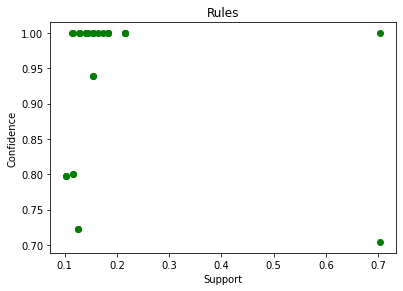

In [42]:
with open("E:/rules.json") as f2:
  rules = [json.loads(each) for each in f2.readlines()]
  rules_sup = [each["sup"] for each in rules]
  rules_conf = [each["conf"] for each in rules]
  fig=plt.figure("rule")
  ax=fig.add_axes([0.1,0.1,0.8,0.8])
  ax.set_title("Rules")
  ax.scatter(rules_sup, rules_conf, marker='o', color='green')
  ax.set_xlabel("Support")
  ax.set_ylabel("Confidence")
  plt.show()

In [43]:
rules

[{'X_set': [['points', 87]],
  'Y_set': [['country', 'US']],
  'sup': 0.1267613247324228,
  'conf': 1.0,
  'lift': 7.888841506751954,
  'jaccard': 0.1267613247324228},
 {'X_set': [['points', 88]],
  'Y_set': [['country', 'US']],
  'sup': 0.11611229233485891,
  'conf': 1.0,
  'lift': 8.612352576039727,
  'jaccard': 0.11611229233485891},
 {'X_set': [['points', 90]],
  'Y_set': [['country', 'US']],
  'sup': 0.11347255756964215,
  'conf': 1.0,
  'lift': 8.812703453751489,
  'jaccard': 0.11347255756964215},
 {'X_set': [['province', 'Washington']],
  'Y_set': [['country', 'US']],
  'sup': 0.1645554794767379,
  'conf': 1.0,
  'lift': 6.076977826444018,
  'jaccard': 0.1645554794767379},
 {'X_set': [['region_2', 'Columbia Valley']],
  'Y_set': [['country', 'US']],
  'sup': 0.1545100724350427,
  'conf': 1.0,
  'lift': 6.472069970845482,
  'jaccard': 0.1545100724350427},
 {'X_set': [['region_2', 'Columbia Valley']],
  'Y_set': [['province', 'Washington']],
  'sup': 0.1545100724350427,
  'conf': 1